# COGS 108 - Final Project
### - Amir Assad, A12721216
### - Danny Chan, A12458661
### - Gunpod Lertkomolsuk, A14190096
### - Tiffany Chang, A14124203
### - Ji Yoon Suh, A14203076

## Introduction and Background

### Background

This is a question of interest because annual shootings in America has become quite common, expected and a pattern. Many questions have been raised to what proper solutions could address the shooting of innocence and although we ourselves may not be able to address the issue directly, we hope to derive information from the data to tell us whether there is a correlation to the issue if the solution gets implemented. There were 372 mass shootings in the US in 2015, killing 475 people and wounding 1,870, according to the Mass Shooting Tracker. The existing problem of mass shooting comes from the loopholes in federal firearms laws of background checking, which requires licensed firearms dealers to sell guns but not unlicensed sellers. 

According to Firearm Acquisition Without Background Checks more than half of Americans acquired firearms with background checks(http://annals.org/aim/fullarticle/2595892/firearm-acquisition-without-background-checks-results-national-survey), that is why we choose to investigate the correlation between background checks and shootings by states. The first reference is an article about the correlations between background checks and shootings. Research shows that there was a 40 percent decline in shooting when Connecticut implemented background checks on firearms. However, if we can see a correlation between states with most background checks to shooting, we can rebuke the study that background checks can make huge impacts on shootings at all. 

In finding this correlation, we will have a main dataset to refer to whether or not the variable we are investigating has a correlation to mass shootings. First, we will investigate number of background checks on guns and handguns to mass shooting in 2015. Next, we will investigate number murders per state categorized by different guns then draw a connection to the main mass shooting dataset in 2015.



### Research Question

Are shootings more likely to happen in states with the top 10% of most background checks done on permits and handguns over the last 10 years?


### Hypothesis

Shootings are more likely to happen in states that are in the top 10% of most background check done


In [552]:
# Imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

## Data Description

### 1. Mass Shootings 2015 
* Link: http://www.gunviolencearchive.org/reports/mass-shootings/2015?page=1
* Number of observations: 173
* Description: This is a list of mass shooting incidents in America for the year 2015. Each data has Date, State, City, Address, number of people killed and number of people injured. This dataset is the base data to refer to when finding correlation from other data sets below. Correlation of data will be drawn from how close it is to this data set.

### 2. NICS monthly figures on background checks for gun buyers
* Link: https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view
* Link: https://github.com/BuzzFeedNews/2017-11-gun-sales-estimates/blob/master/data/nics-firearm-background-checks.csv
* Number of observations: 12541
* Description: This NICS dataset contains the amount of background checks done for permits, handguns, long_guns, etc for every state per month from 1998 to 2017. This dataset will be used to to be a hypothesis on whether or not we have a correlation of background checks with the mass shootings. We will observe the total amount of background checks done for every state in 2015 and see if we are able to predict the number of incident occurence. We also think that the top 10 state for most mass shooting incident will overlap with the top 10 state with the most total background checks and handgun.

### 3. Murders by State, Types of Weapon, 2015 in US
* Link: https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-20/table_20_murder_by_state_types_of_weapons_2015.xls/@@template-layout-view?override-view=data-declaration
* Number of observations: 53
* Description: This is a FBI dataset from Table 20 which has incofrmation of homocide murders in 2015 by state and type of weapon used in this homocide murders. This data is collected by the FBI throught the Uniform Crime Reporting (UCR) Program, some states(Florida, Illinois and Alabama) did not meet the standars, therefore their homocide data may be limited in this table. We will use this dataset to see if there are any correlations between the homocide murders and mass shootings. We will assume the larger the number of homocides in a state the more frequent the mass shootings will be.

### 4. Gun Laws Grade by State, 2017 in US
* Link: http://lawcenter.giffords.org/scorecard/#MN
* Number of observations: 1567
* Description: This is a data from Giffords Law Center where they grade gun laws by state giving it rank from A to F. Its website is one gigantic infomatics about gun laws and its correlation to gun death rates. It serves the purpose to raise awareness for how gun laws and regulations may reduec death caused by guns. The dataset we will be using from this website is the 50 states rank of gun laws by state.

## Data Cleaning/Pre-processing

In [553]:
# Import the data from all files into Dataframes
df_shootings = pd.read_csv(open('shootings.csv'))
df_background_checks = pd.read_csv(open('nics-firearm-background-checks.csv'))
murder_by_state_by_weapon = pd.read_csv(open("murderByStateByWeapon.csv"))
df_gun_laws = pd.read_csv(open('gun_laws_bright.csv'))
df_gun_laws_self = pd.read_csv(open('self_gun_laws.csv'))


### Dataset 1

In [554]:
df_shootings.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,"December 31, 2015",Louisiana,New Orleans,1900 block of Amelia Street,0,6,NaN
1,"December 27, 2015",Tennessee,Jackson,North Parkway,0,4,NaN
2,"December 26, 2015",Pennsylvania,Philadelphia,4210 Macalester St,0,4,NaN
3,"December 25, 2015",Florida,Jacksonville,Franklin and Odessa,0,4,NaN
4,"December 25, 2015",Alabama,Mobile,785 Schillinger Rd S,0,4,NaN


Creating two new dataframe, one for the total number of incidents per state and another for total affected per state (injured + killed)

In [555]:
# Create two new dataframe
incident_count = {}
affected_count = {}
for i, row in df_shootings.iterrows():
    if row['State'] in incident_count:
        incident_count[row['State']] += 1
    else:
        incident_count[row['State']] = 1
        
    if row['State'] in affected_count:
        affected_count[row['State']] += (int(row['# Killed']) + int(row['# Injured']))
    else:
        affected_count[row['State']] = (int(row['# Killed']) + int(row['# Injured']))

In [556]:
# Swap the columns to be indexed of the dataframe
df_incident = pd.DataFrame([incident_count]).transpose()
df_affected = pd.DataFrame([affected_count]).transpose()
df_incident.columns = ['# Incident']
df_affected.columns = ['# Affected']

### Dataset 2

In [557]:
df_background_checks.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-10,Alabama,20017.0,252.0,6144.0,6999.0,308.0,337,0.0,15.0,...,0.0,0.0,0.0,14.0,18.0,1.0,0.0,0.0,0.0,36619
1,2017-10,Alaska,198.0,0.0,3153.0,3469.0,333.0,239,0.0,6.0,...,0.0,0.0,0.0,33.0,38.0,2.0,0.0,0.0,0.0,8080
2,2017-10,Arizona,6097.0,455.0,10614.0,8055.0,1100.0,689,0.0,10.0,...,0.0,0.0,0.0,30.0,17.0,1.0,1.0,0.0,0.0,29277
3,2017-10,Arkansas,3865.0,508.0,4873.0,7420.0,249.0,338,41.0,11.0,...,0.0,0.0,0.0,25.0,20.0,0.0,1.0,1.0,0.0,20327
4,2017-10,California,49259.0,0.0,39879.0,25749.0,3646.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119395


Parse the month column to add a near year column to bucket these data later

In [558]:
# Split the string by '-' and take the year
def extract_year (input):
    return int(input.split('-')[0])

# Apply new function on 'month' column and create new 'year' column
df_background_checks['year'] = df_background_checks['month'].apply(extract_year)

In [559]:
# Define function to create a new dataframe for specifc year and column
def create_bg_dataframe(df, year, column):
    temp_df = df[df['year'] == year]
    state_count = {}
    for i, row in temp_df.iterrows():
        if row['state'] in state_count:
            state_count[row['state']] += int(row[column])
        else:
            state_count[row['state']] = int(row[column])
    new_df = pd.DataFrame([state_count])
    new_df = new_df.transpose()
    return new_df

Create a new dataframe for the total background checks for states in 2015

In [560]:
df_2015_total = create_bg_dataframe(df_background_checks, 2015, 'totals')
df_2015_total.columns = ['total_background_checks']
df_2015_total_sorted = df_2015_total.sort_values('total_background_checks')[::-1]

Another dataframe for background checks done for handgun for state in 2015

In [561]:
df_2015_handgun = create_bg_dataframe(df_background_checks, 2015, 'handgun')
df_2015_handgun_sorted = df_2015_handgun.sort_values(0)[::-1]

Remove irrelevant years from the dataframe

In [562]:
df_2006_2015 = df_background_checks[df_background_checks['year'] >= 2006]
df_2006_2015 = df_2006_2015[df_background_checks['year'] <= 2015]

In [563]:
# Bucket by year for total count and handgun count
year_count_total = {}
year_count_handgun = {}
for i, row in df_2006_2015.iterrows():
    if row['year'] in year_count_total:
        year_count_total[row['year']] += int(row['totals'])
    else:
        year_count_total[row['year']] = int(row['totals'])
    if row['year'] in year_count_handgun:
        year_count_handgun[row['year']] += int(row['handgun'])
    else:
        year_count_handgun[row['year']] = int(row['handgun'])

Total count of background checks from 2006 to 2015

In [564]:
# Create dataframe from buckets for total 
df_year_total = pd.DataFrame([year_count_total])
df_year_total = df_year_total.transpose()
df_year_total.columns = ['total_count']
print(df_year_total)

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


Total count of background checks done for handgun from 2006 to 2015

In [565]:
# Create dataframe from buckets for handgun
df_year_handgun = pd.DataFrame([year_count_handgun])
df_year_handgun = df_year_handgun.transpose()
df_year_handgun.columns = ['handgun_count']
print(df_year_handgun)

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


### Dataset 3

Here is a look at our data which represents the number of homocide murders in each state in the US

In [566]:
murder_by_state_by_weapon.head()

,State,Total murders,Handguns,Rifles,Shotguns
0,Alabama,2,1,0,1
1,Alaska,15,12,2,1
2,Arizona,135,128,4,3
3,Arkansas,65,51,10,4
4,California,922,855,34,33


Here we set the index to be "State" and we create another dataframe excluding the "Total Murders" column

In [567]:
gun_types = ['Handguns','Shotguns', 'Rifles']
murder_by_state_by_weapon.set_index('State', inplace=True)
murders_by_state = murder_by_state_by_weapon[gun_types]

We will concatinate the homocide df and masshootings df into one
We will also fill any NA to zero
Some columns may be NA as the mass shootings data do not nessasarily get registered as homocide or there could have been no casualties but only injuries. 

In [568]:
murder_by_state_by_weapon_VS_mass_shootings = pd.concat([murder_by_state_by_weapon, df_incident, df_affected], axis=1)
murder_by_state_by_weapon_VS_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings.fillna(0)


### Dataset 4

In [569]:
# Eyeball gun laws by weight
df_gun_laws.head()

,Rank,State,Grade,Death rates by rank,Gun death rate
0,36,Alabama,F,2,21.4
1,44,Alaska,F,1,23.0
2,47,Arizona,F,16,15.2
3,39,Arkansas,F,9,17.7
4,1,California,A,43,7.9


Clean up data and give Grade by ranking of 1 to 15

In [570]:
df_gun_laws = df_gun_laws[['State', 'Grade']]

grade_dict = {
    'A+':15,
    'A':14,
    'A-':13,
    'B+':12,
    'B':11,
    'B-':10,
    'C+':9,
    'C':8,
    'C-':7,
    'D+':6,
    'D':5,
    'D-':4,
    'F+':3,
    'F':2,
    'F-':1,
}
def standerdized_stateGrade(grade):
    try:
        a = grade_dict[grade]
        return a
    except KeyError:
        return Nan
df_gun_laws['Grade']= df_gun_laws['Grade'].apply(standerdized_stateGrade)



In [571]:
df_gun_laws_self.columns = ['states', 'laws', 'handguns']
df_gun_laws_self.head()
self_state = df_gun_laws_self.states.unique()

df_gun_laws_self.drop(df_gun_laws_self.index[0], inplace=True)
df_gun_laws_self['states'].fillna('state', inplace = True)

for i, state in df_gun_laws_self.iterrows():
    if state[0] == "state":
        df_gun_laws_self.states[i] = df_gun_laws_self.states[i-1]
        
df_gun_laws_self = df_gun_laws_self[(df_gun_laws_self['handguns'] == 'Yes') | (df_gun_laws_self['handguns'] == 'yes')]
df_law_count = df_gun_laws_self.groupby('states').count()


Seperate set of df sorted by Rank incase use and add States that are missing when compared to 2015 mass shootings. Sort it by state to help when creating concat df


In [572]:
# Clean data for df incidents vs gun laws linear regression
df_incident_41=df_incident.drop(df_incident.index[[7]]) 
df_incident_41.columns=['incident']
df_gun_laws=df_gun_laws.set_index('State')
df_gun_laws_41=df_gun_laws.drop(['Alaska','Hawaii','Idaho','Maine','New Hampshire','North Dakota','Utah','West Virginia','Wyoming'])

# Clean data for df incidents vs self gun laws linear regression
df_law_count = df_law_count[['laws']]
df_law_count_42=df_law_self.drop(df_law_self.index[[1,11,12,19,29,34,44,48,50]]) 



## Data Visualization

### Dataset 1

Sorted bar graph of state for total # of incidents and affected

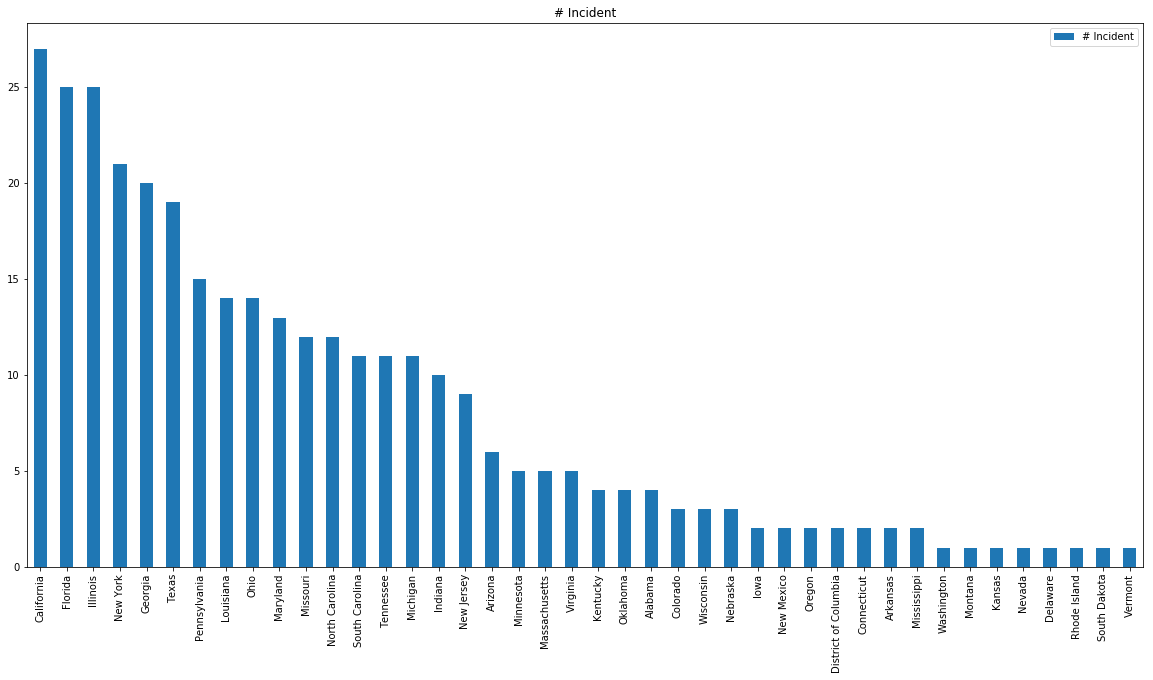

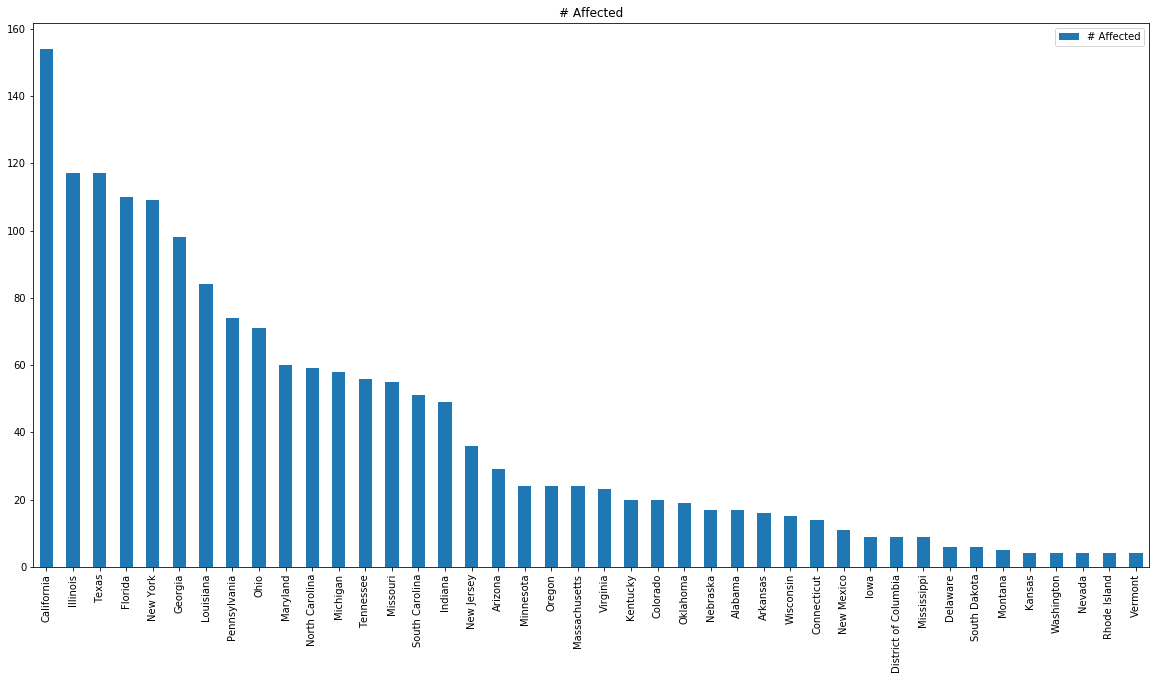

In [573]:
df_incident.sort_values('# Incident')[::-1].plot(kind='bar', figsize=(20,10), title='# Incident')
df_affected.sort_values('# Affected')[::-1].plot(kind='bar', figsize=(20,10), title='# Affected')


In [574]:
df_shootings_incident_affected = pd.concat([df_incident, df_affected], axis=1)
df_shootings_incident_affected.head()

,# Incident,# Affected
Alabama,4,17
Arizona,6,29
Arkansas,2,16
California,27,154
Colorado,3,20


### Dataset 2

For our background check dataset, we have the total amount of background checks and the top 10 states with the most background check in bar graphs. The purpose of this is we want to see if we can create a correlation of total background checks with shootings later. 

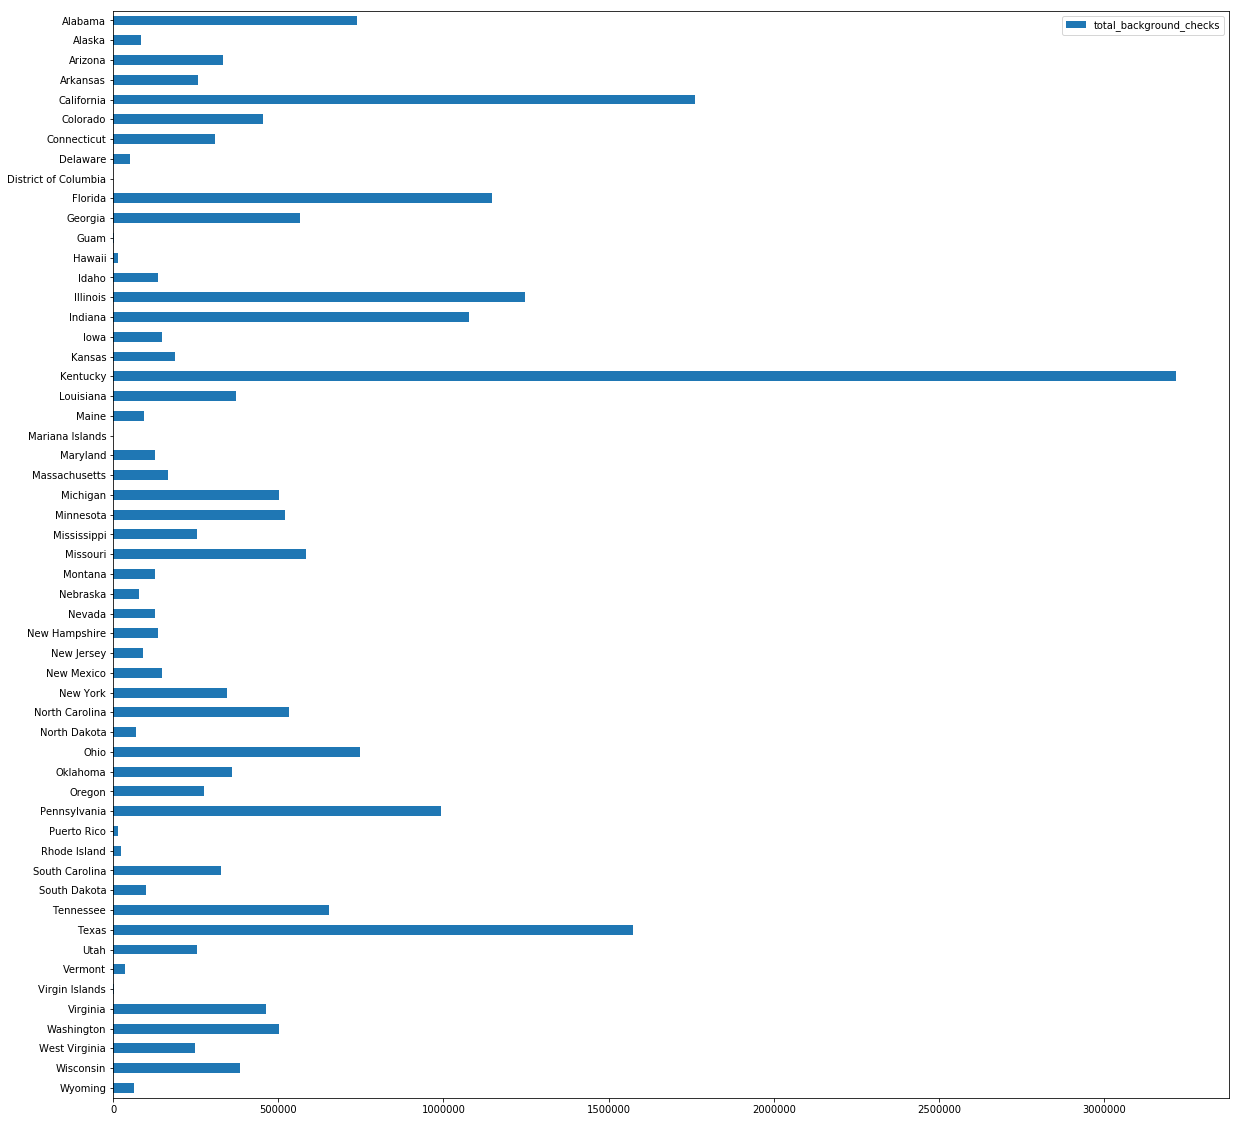

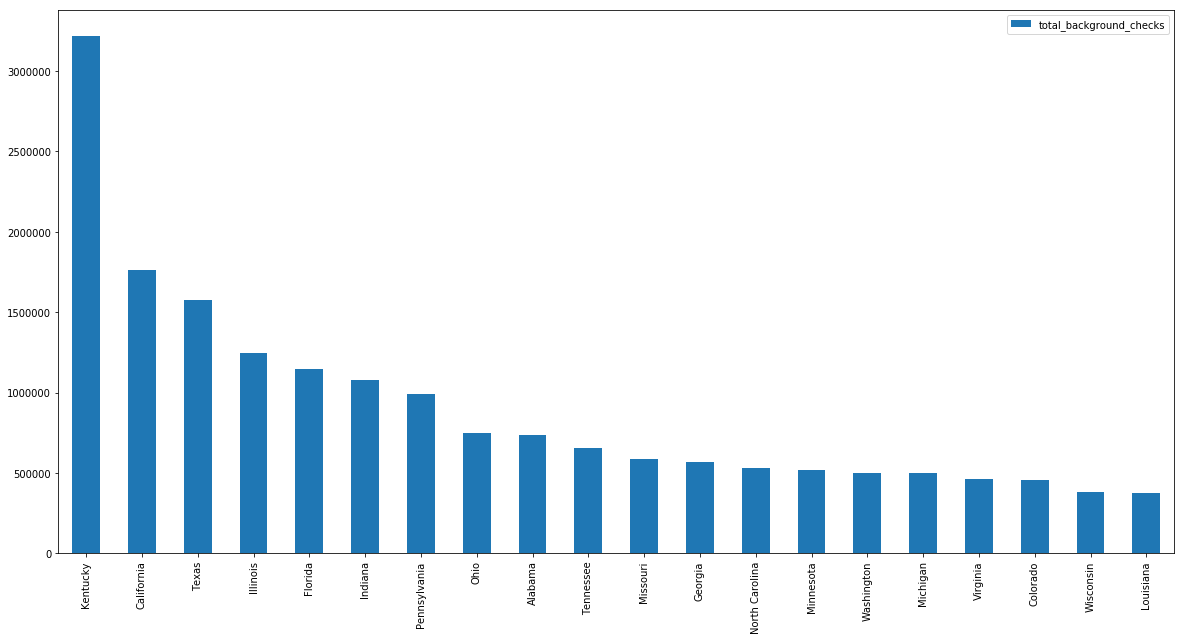

In [575]:
df_2015_total[::-1].plot(kind='barh', figsize=(20,20))
df_2015_total_sorted[:20].plot(kind='bar', figsize=(20,10))

The second dataframe we created from this datatset is the total of handgun background checks done in 2015. We have the total amount per state and the top 10 states with most handgun background checks. We have a secondary dataset we want to compare with the mass shootings, since we don't want to only think total background check is related.

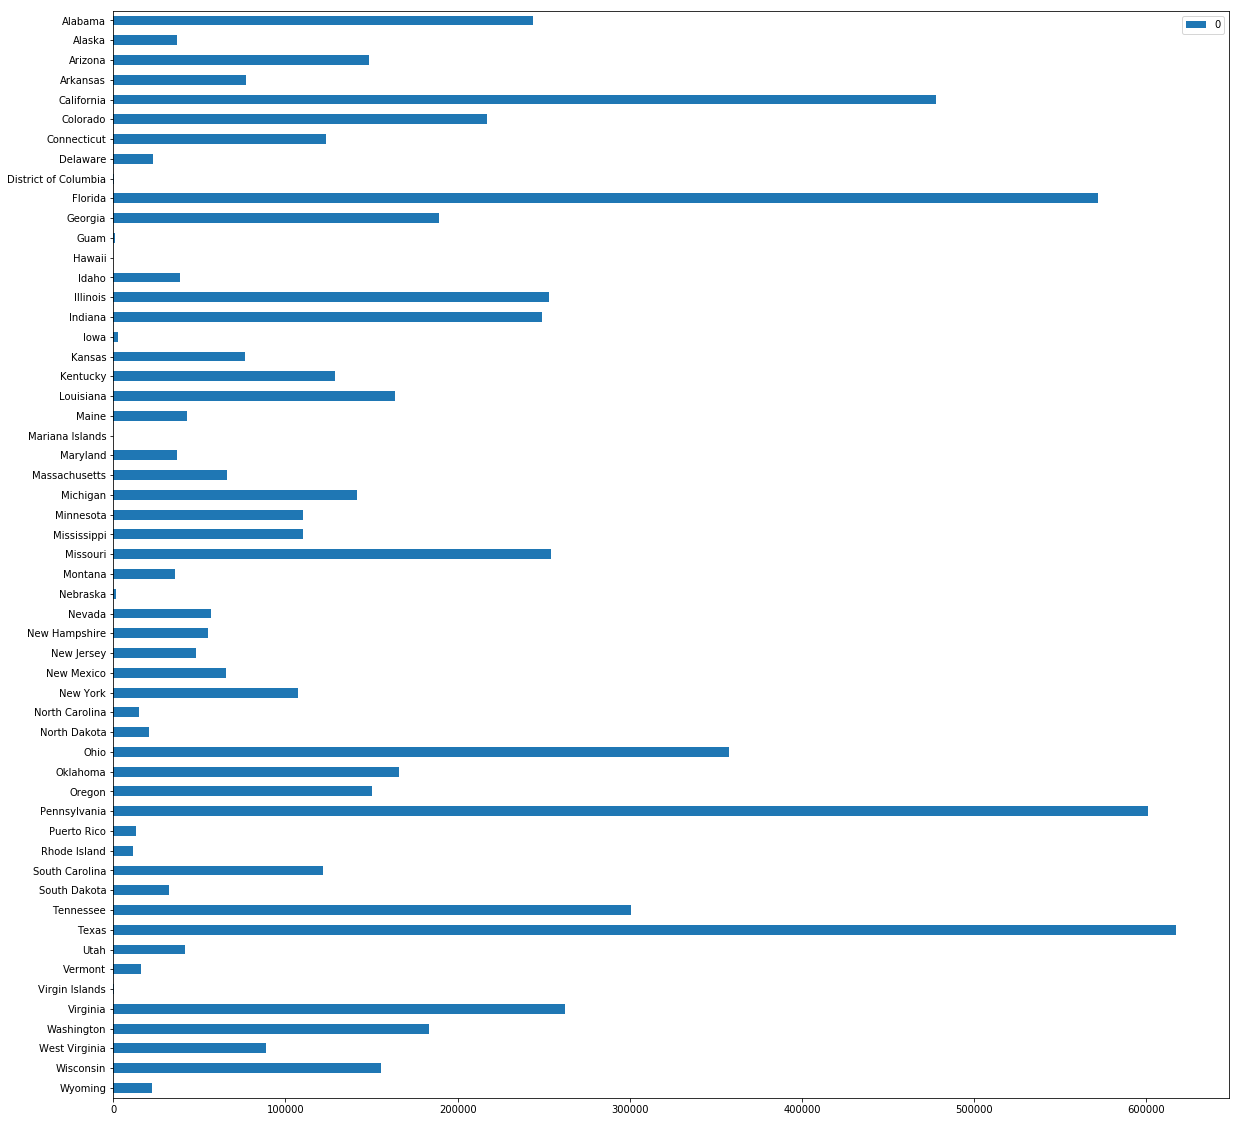

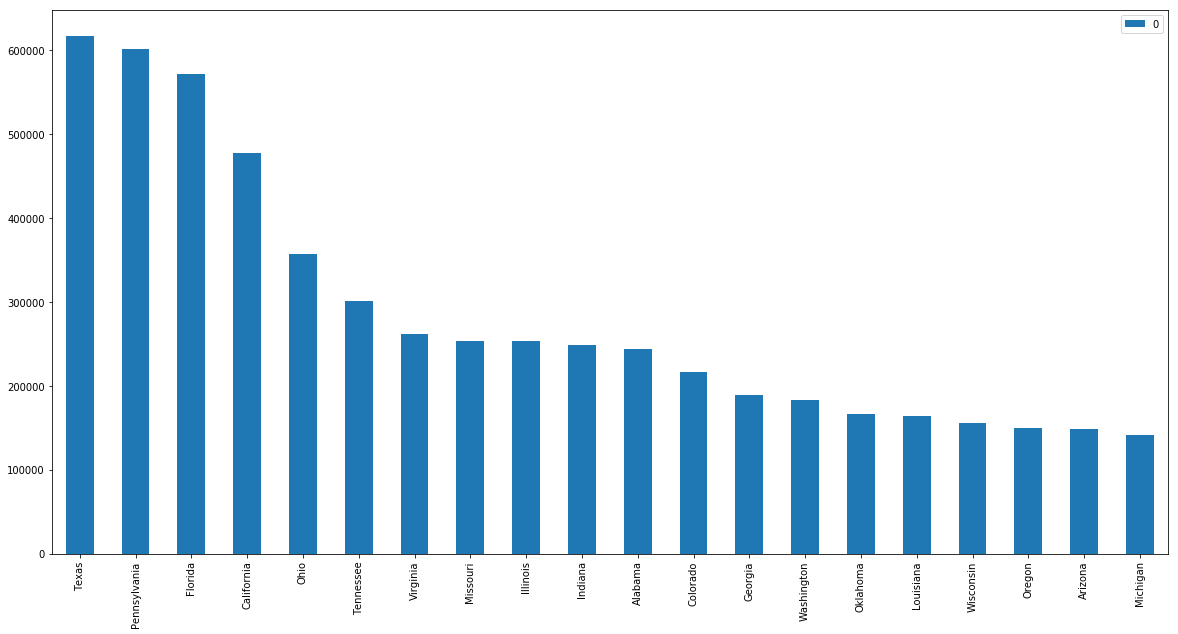

In [576]:
df_2015_handgun[::-1].plot(kind='barh', figsize=(20,20))
df_2015_handgun_sorted[:20].plot(kind='bar', figsize=(20,10))

We have a line graph of how the background checks increased over the past 10 years

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


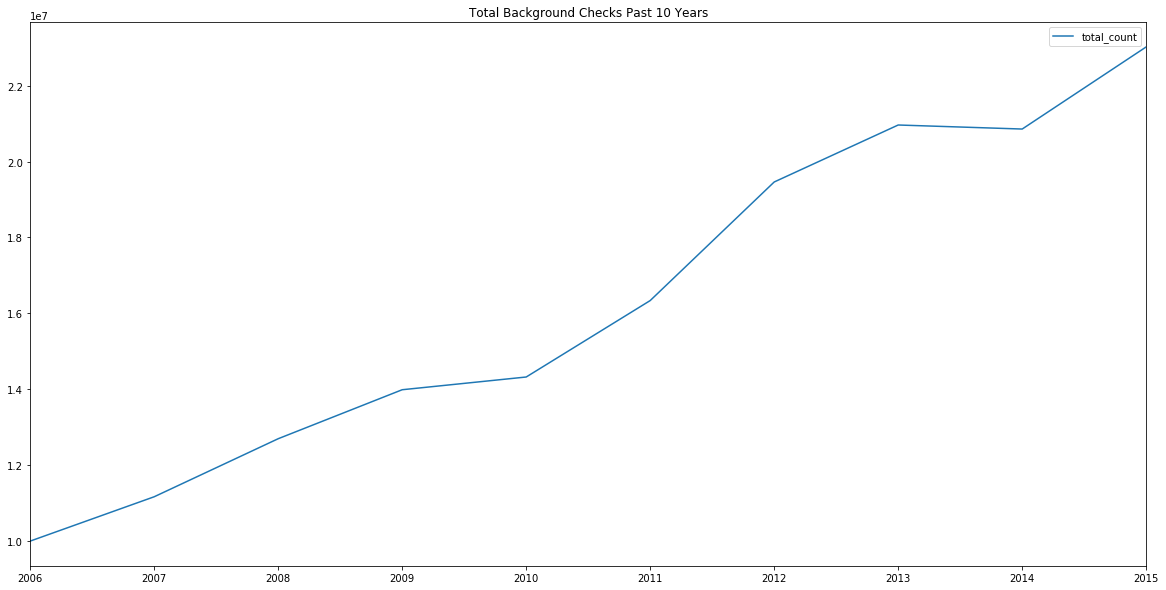

In [577]:
print(df_year_total)
df_year_total.plot(figsize=(20,10), title='Total Background Checks Past 10 Years')

We also have the total handgun background checks done over the past 10 years.

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


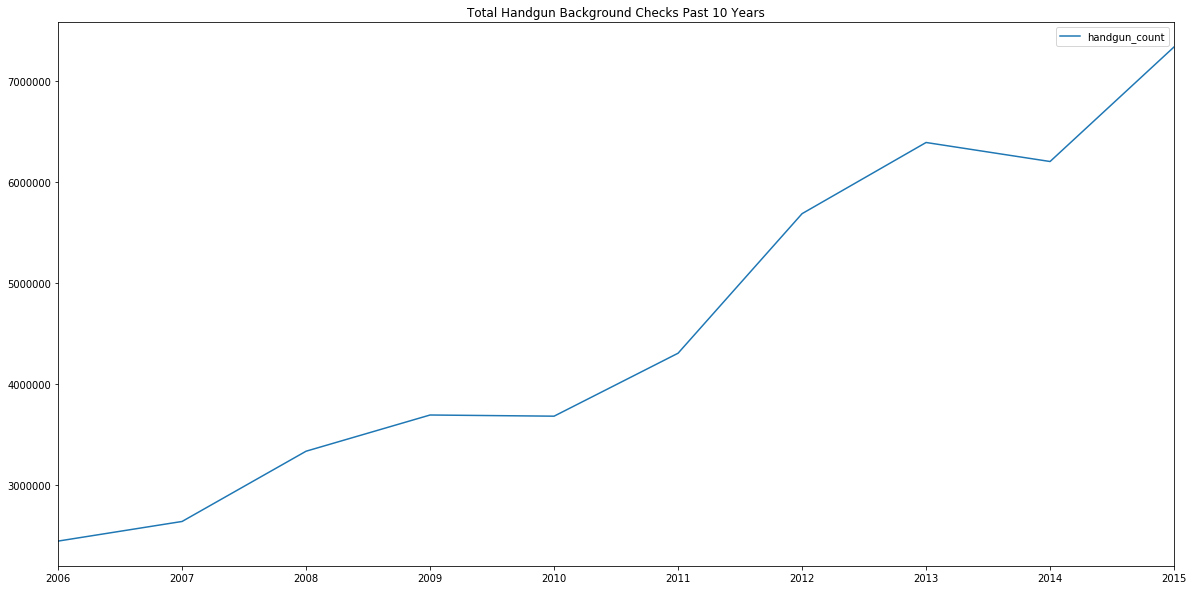

In [578]:
print(df_year_handgun)
df_year_handgun.plot(figsize=(20,10), title='Total Handgun Background Checks Past 10 Years')

### Dataset 3

In [579]:
murders_by_state.head()

,Handguns,Shotguns,Rifles
State,,,
Alabama,1,1,0
Alaska,12,1,2
Arizona,128,3,4
Arkansas,51,4,10
California,855,33,34


Here is a bar plot of the murders by weapons in each state 

[Text(0,0.5,'Murders'),
 Text(0.5,0,'State'),
 Text(0.5,1,'Murders per state by weapon')]

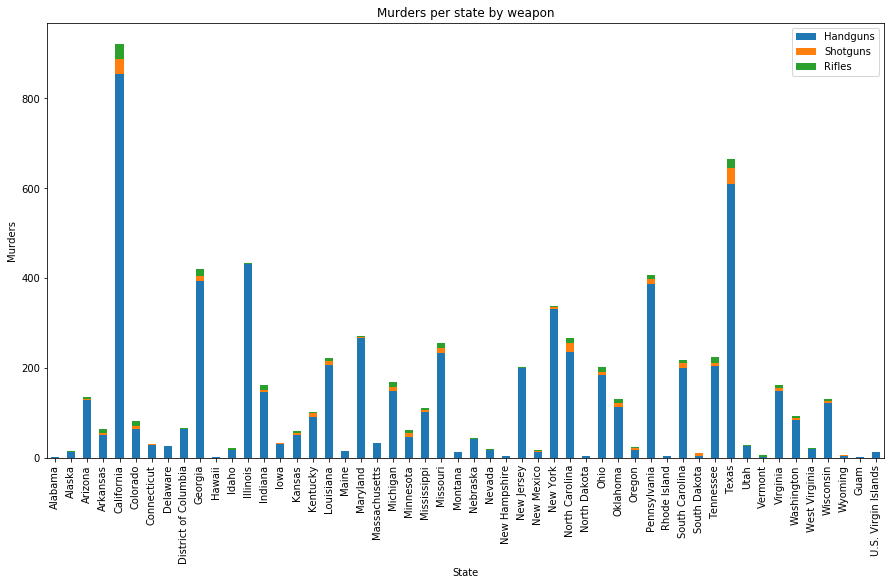

In [580]:
axes = murders_by_state.plot.bar(figsize=(15,8), stacked=True)
axes.set(xlabel="State", ylabel="Murders", title="Murders per state by weapon")

Here we plot a histogram chart and we see the distribution of murders by weapon in each state

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c235e3240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2c878c18>]], dtype=object)

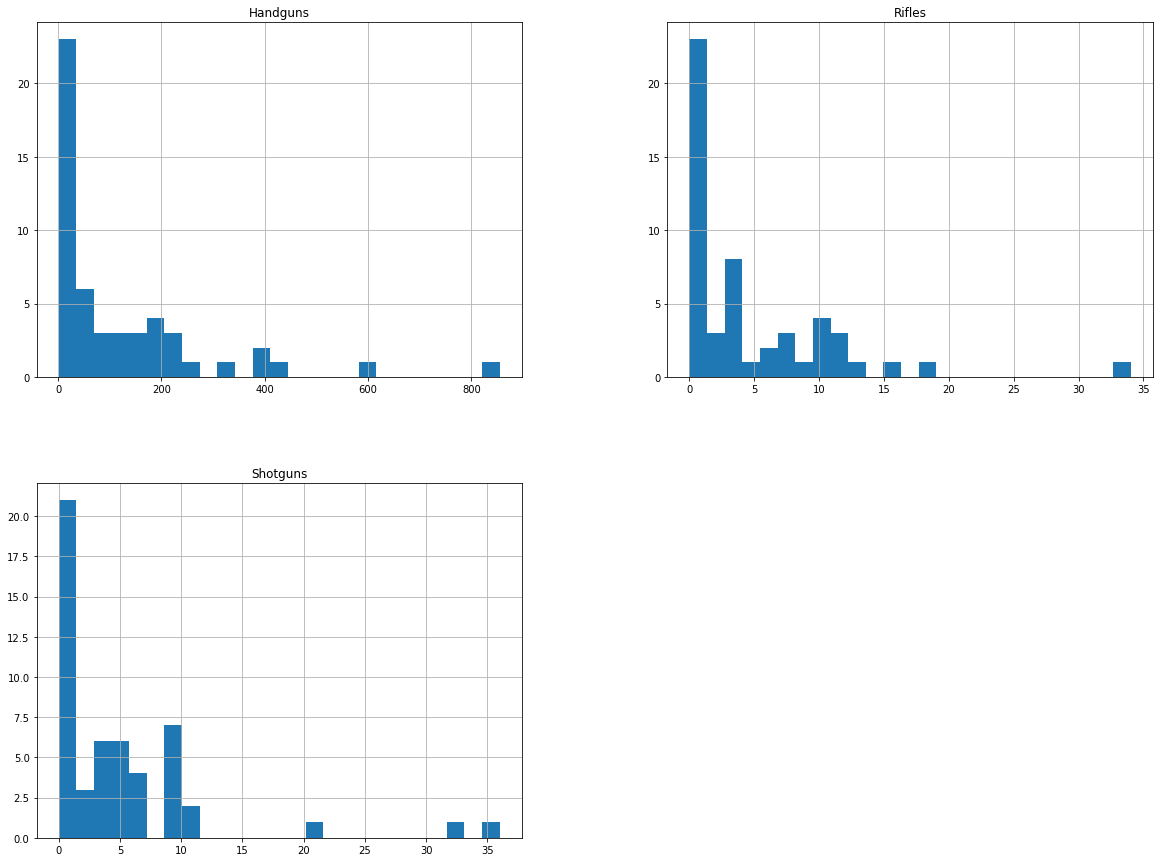

In [581]:
murders_by_state.hist(bins=25, weights=np.ones_like(murders_by_state[murders_by_state.columns[0]]), figsize=(20, 15))

### Dataset 4

[Text(0,0.5,'Law Grade'), Text(0.5,0,'State'), Text(0.5,1,'Gun Law Weight')]

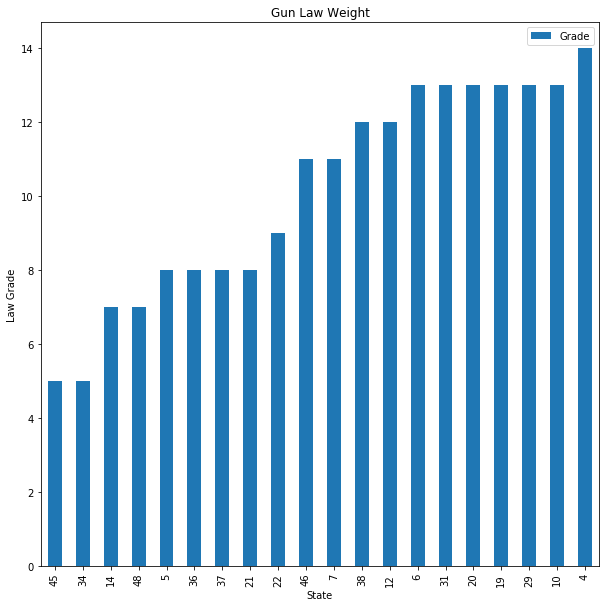

In [582]:
# gun laws sorted top 20 states by grade
gun_x=df_gun_laws_sorted[30:].plot(kind='bar', figsize=(10,10));
gun_x.set(xlabel="State", ylabel="Law Grade", title="Gun Law Weight")

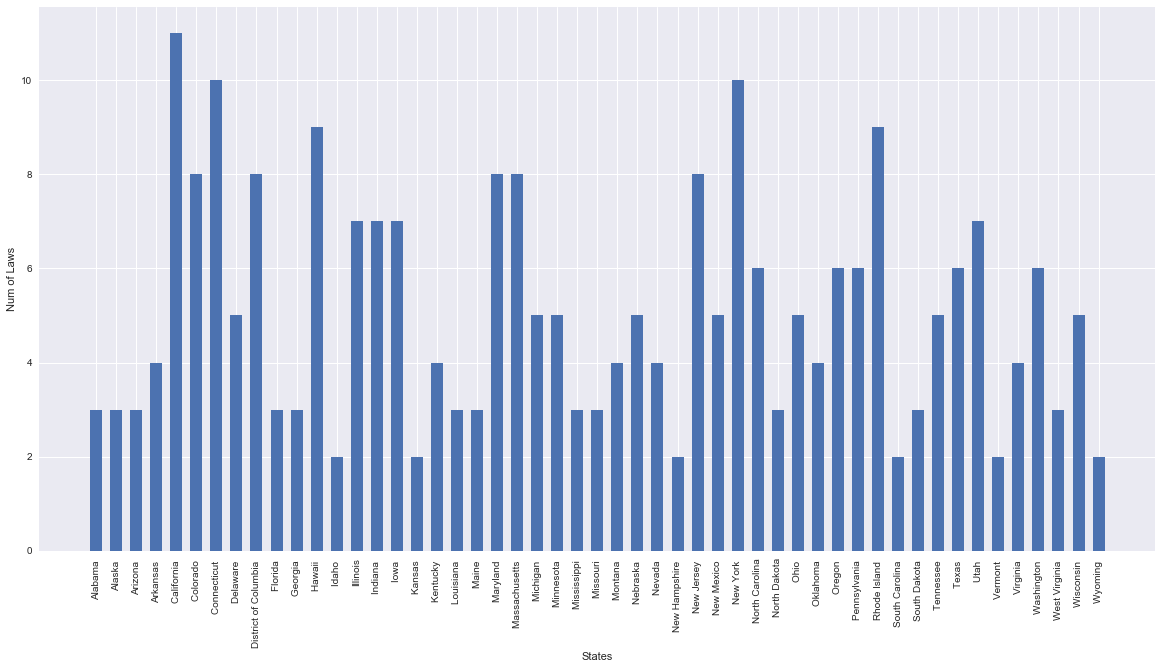

In [620]:
x = df_law_count.index
y = df_law_count['laws']

plt.bar(x,y, width=0.6, align='center')
plt.xlabel('States')
plt.xticks(rotation=90)
plt.ylabel('Num of Laws')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
# print(fig_size)
plt.show()

## Data Analysis and Results

### Dataset 2

First we will combine our dataframe to do our analysis against of main dataframe, mass shootings. 

In [583]:
# Combine out original datatset with the mass shooting dataset 
df_2015_total_merge = pd.concat([df_2015_total, df_incident], axis=1)

# Since not all states has a incident, we will replace the NaN values with 0.
df_2015_total_merge.fillna(0, inplace=True)
df_2015_total_merge.head(20)

,total_background_checks,# Incident
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0
Colorado,454062,3.0
Connecticut,307750,2.0
Delaware,50416,1.0
District of Columbia,742,2.0
Florida,1147082,25.0


Used scatter matrix to analyze different the trend between the variable we have compare to the base table

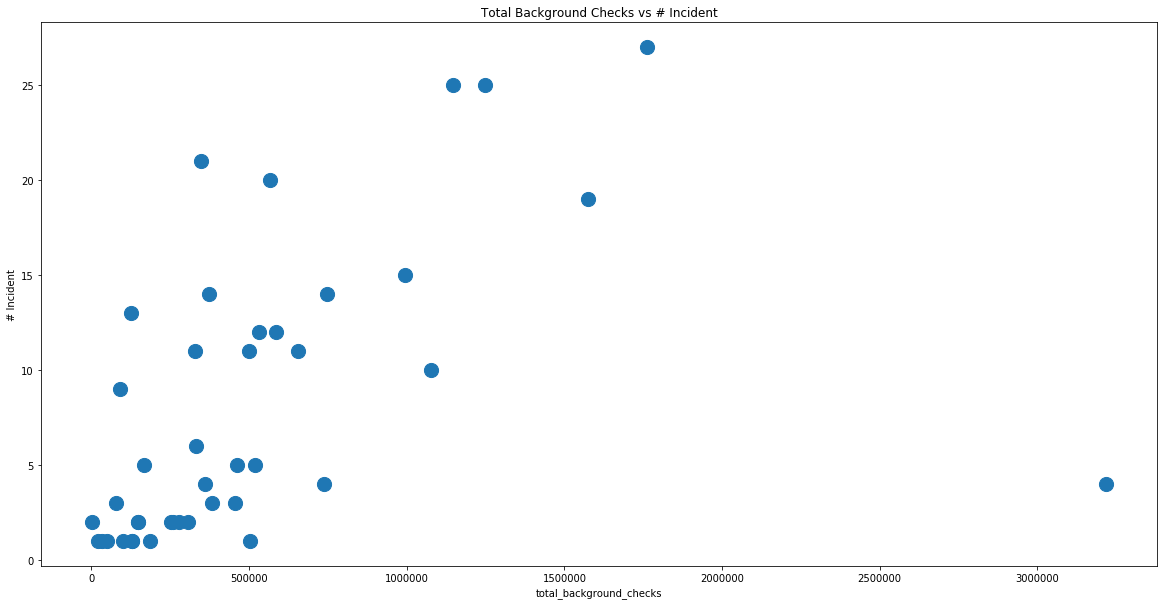

In [584]:
df_2015_total_merge[df_2015_total_merge['# Incident'] > 0].plot(x='total_background_checks', y='# Incident', kind='scatter', figsize=(20,10), s=200, title='Total Background Checks vs # Incident')

In [585]:
df_2015_total_merge.columns = ['total', 'incidents']
df_2015_total_merge.head()

,total,incidents
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0


Apply linear regression to see whether there are any correlation in our data with the base table.

In [586]:
df_2015_clean = df_2015_total_merge[df_2015_total_merge['incidents'] > 0]
out, pred = patsy.dmatrices('incidents ~ total', df_2015_clean)
mod = sm.OLS(out, pred)
res = mod.fit()

In [587]:
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.45
Date:                Thu, 22 Mar 2018   Prob (F-statistic):            0.00161
Time:                        00:41:46   Log-Likelihood:                -139.10
No. Observations:                  42   AIC:                             282.2
Df Residuals:                      40   BIC:                             285.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7702      1.405      3.396      0.0

Top 10 Most Background Checks vs Top 10 Most Incident

In [588]:
print(df_incident.sort_values('# Incident')[::-1].head(10))
print(df_2015_total_sorted.head(10))

              # Incident
California            27
Florida               25
Illinois              25
New York              21
Georgia               20
Texas                 19
Pennsylvania          15
Louisiana             14
Ohio                  14
Maryland              13
              total_background_checks
Kentucky                      3218371
California                    1761079
Texas                         1574266
Illinois                      1247398
Florida                       1147082
Indiana                       1076917
Pennsylvania                   993429
Ohio                           748502
Alabama                        737509
Tennessee                      654192


By looking at the intersection of the two list we have an overlap of 6 states.

In [589]:
list(set(df_incident.sort_values('# Incident')[::-1][:10].index).intersection(df_2015_total_sorted[:10].index))

['Texas', 'Pennsylvania', 'Ohio', 'Illinois', 'California', 'Florida']

We will now compare the handgun total in the same dataset, to see if the values will change

In [590]:
# Combine out original datatset with the mass shooting dataset 
df_2015_handgun_merge = pd.concat([df_2015_handgun, df_incident], axis=1)

# Since not all states has a incident, we will replace the NaN values with 0.
df_2015_handgun_merge.fillna(0, inplace=True)

Analyze the total handgun background check with # of incidents with linear regression to see if there's any correlation with these two datasets

In [591]:
df_2015_handgun_merge.columns = ['handgun', 'incidents']

# Drop rows with 0 incidents
df_2015_clean_handgun = df_2015_handgun_merge[df_2015_handgun_merge['incidents'] > 0]

# Perform OLS analysis
out, pred = patsy.dmatrices('incidents ~ handgun', df_2015_clean_handgun)
mod = sm.OLS(out, pred)
res = mod.fit()

In [592]:
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     30.95
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.94e-06
Time:                        00:41:46   Log-Likelihood:                -132.35
No. Observations:                  42   AIC:                             268.7
Df Residuals:                      40   BIC:                             272.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7084      1.296      2.090      0.0

From analyzing the data with just handgun we came to similiar results from total background checks.

In [593]:
list(set(df_incident.sort_values('# Incident')[::-1][:10].index).intersection(df_2015_handgun_sorted[:10].index))

['Texas', 'Pennsylvania', 'Ohio', 'Illinois', 'California', 'Florida']

### Dataset 3

In [594]:
murder_by_state_by_weapon_VS_mass_shootings.head()

,Total murders,Handguns,Rifles,Shotguns,# Incident,# Affected
Alabama,2.0,1.0,0.0,1.0,4.0,17.0
Alaska,15.0,12.0,2.0,1.0,0.0,0.0
Arizona,135.0,128.0,4.0,3.0,6.0,29.0
Arkansas,65.0,51.0,10.0,4.0,2.0,16.0
California,922.0,855.0,34.0,33.0,27.0,154.0


In [595]:
#set the figure size of the plot
sns.set(rc={'figure.figsize':(20,10)})

Use the scatter matrix to compare the trends of homocide murders vs number of people affected in a mass shooting incidents

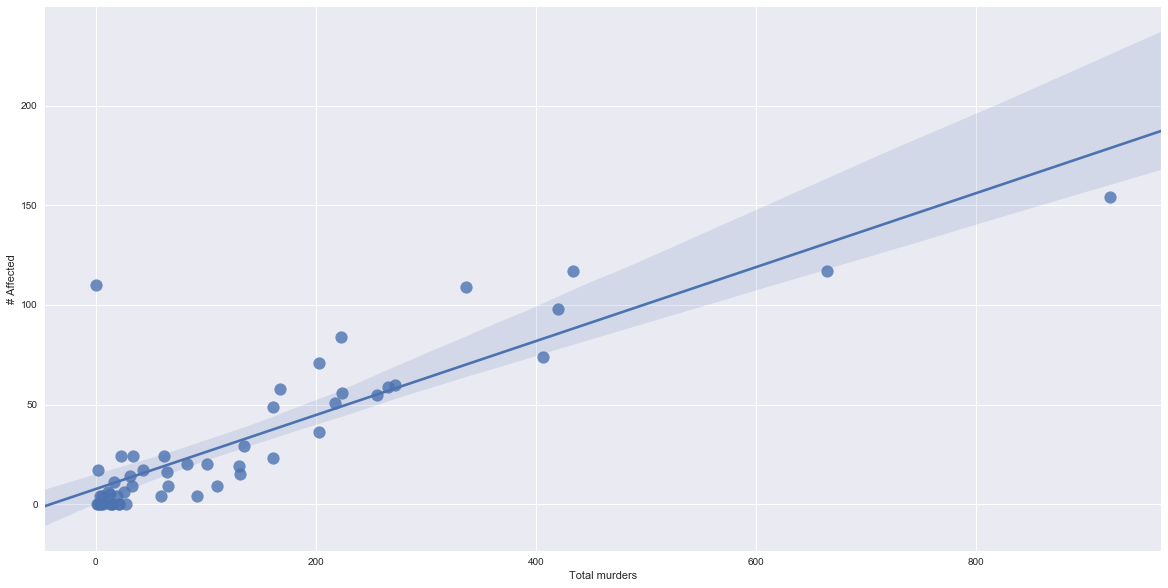

In [596]:
sns.regplot(x='Total murders', y='# Affected', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True,  scatter_kws={'s':150 })

Use the scatter matrix to compare the trends of homocide murders vs number of mass shooting incident per state

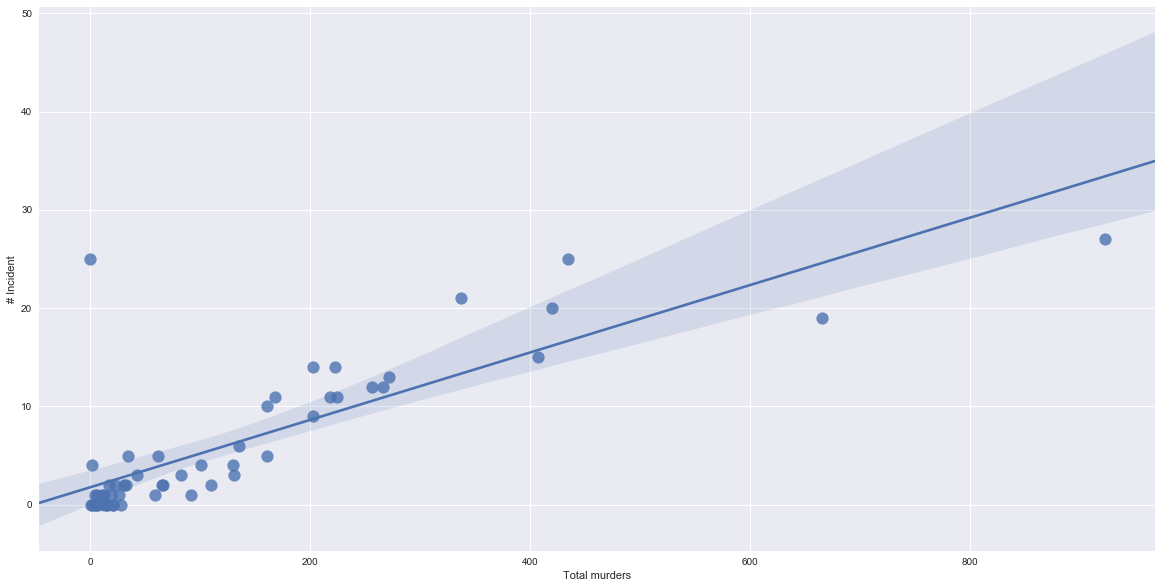

In [597]:
sns.regplot(x='Total murders', y='# Incident', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True, scatter_kws={'s':150 }) 

Below we will do a linear regression test to see the correlation between # of homocide murders and mass shootings 

In [598]:
# Create two df that contain the total homocide murders vs people affect & number of incidents
total_murders_VS_mass_shooting_incidents = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Incident']]
total_murders_VS_people_affected_in_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Affected']]

In [599]:
total_murders_VS_mass_shooting_incidents.columns = ['murders', 'incidents']
total_murders_VS_people_affected_in_mass_shootings.columns = ['murders', 'affected']

In [600]:
total_murders_VS_mass_shooting_incidents.head()

,murders,incidents
Alabama,2.0,4.0
Alaska,15.0,0.0
Arizona,135.0,6.0
Arkansas,65.0,2.0
California,922.0,27.0


In [601]:
out, pred = patsy.dmatrices('incidents ~ murders', total_murders_VS_mass_shooting_incidents)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     101.5
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.01e-13
Time:                        00:41:48   Log-Likelihood:                -152.50
No. Observations:                  53   AIC:                             309.0
Df Residuals:                      51   BIC:                             312.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7724      0.750      2.362      0.0

We have achieved a p value of 0.022 which can be statistically significant 

In [602]:
total_murders_VS_people_affected_in_mass_shootings.head()

,murders,affected
Alabama,2.0,17.0
Alaska,15.0,0.0
Arizona,135.0,29.0
Arkansas,65.0,16.0
California,922.0,154.0


In [603]:
out, pred = patsy.dmatrices('affected ~ murders', total_murders_VS_people_affected_in_mass_shootings)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               affected   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     146.3
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.34e-16
Time:                        00:41:55   Log-Likelihood:                -232.31
No. Observations:                  53   AIC:                             468.6
Df Residuals:                      51   BIC:                             472.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5677      3.382      2.238      0.0

We have achieved a p value of 0.030 which can be statistically significant 

### Dataset 4

In [604]:
# # Linear modeling on grade for gun laws as predicting variable

df_gun_laws_linear1 = df_incident_41.assign(Grade=df_gun_laws_41.Grade)
out, pred = patsy.dmatrices('incident ~ Grade', df_gun_laws_linear1)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:               incident   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9988
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.324
Time:                        00:41:55   Log-Likelihood:                -140.61
No. Observations:                  41   AIC:                             285.2
Df Residuals:                      39   BIC:                             288.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3922      2.064      3.098      0.0

In [634]:
# # # #Linear modeling on gun regulation self built as predicting variable

df_incident.columns=['incident']
laws=df_law_count_42.laws.values
df_gun_laws_linear2 = df_incident.assign(laws=laws)

out, pred = patsy.dmatrices('incident ~ laws', df_gun_laws_linear2)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())






                            OLS Regression Results                            
Dep. Variable:               incident   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.943
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.171
Time:                        00:49:27   Log-Likelihood:                -143.39
No. Observations:                  42   AIC:                             290.8
Df Residuals:                      40   BIC:                             294.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1661      2.939      1.418      0.1

## Privacy/Ethics Considerations

To protect people’s privacy, we must remove any personal information if included in the data sets such as names, phone numbers, age, IP address, and so on.
Because there a shooting has occurred recently in a Florida high school, we must be sensitive and be compassionate towards the victims and their families. 


## Conclusion and Discussion

After analyzing the background dataset to see if there’s any strong correlation to mass shootings, we concluded that there isn’t a strong prominent correlation. However by doing the analysis we were able to see some similarities and small correlation. First off, after doing the regression testing on the two smaller dataset, handgun checks vs total checks there was no significant difference, they almost gave the same result. This could be due to that fact that the hand gun checks are a big contribution to the total background checks. However, we can achieve a p-value of 0.002 which means there is a statistical significance but we have a large conditional number and small standard error value. Although this may mean theres a chance for a correlation but it just isn’t strong enough to say directly. But by looking at the scatter plot, we do see a small linear growth of total background checks vs # of incident per state. When visually analyzing these result, this doesn’t show as valuable as the information should be because we didn’t take into account the size of the state which could make the # of incident per state scale up a lot more than other states. However when doing a simple comparison of top 10 state with most incident in 2015 and top 10 state with most background check, we have an overlap of 6 out of those 10 states, Ohio, Texas, California, Pennsylvania, Illinois. Therefore, there is a small correlation between background checks and mass shooting, but not big enough where we could predict feature events.

We also analyzed the relation between firearm regulations in each state and number of gun-related incidents. The p-value for gun regulation grade vs incidents is 0.004, which suggests that there is a statistical significance between how strict/thorough gun policies are in each state and the number of gun-related incidents. Although there is no direct impact of this finding on our hypothesis, this might be a useful insight for future analysis regarding mass shootings.

After analyzing the homocide dataset to see if there is any strong correlation to mass shootings, we concluded that there is a correlation between the murders in each state and the mass shootings that have occured in that state. In a state where there are many homocide incidents suggests there is a greater rate of violance and a greater chance to have a mass shooting incident, compared to a state that has a low homocide rate. Looking at the linear regression model and using an aplha value of 0.05 we recieved a value of 0.022 and 0.030 for #incidents & # affected respectively. These values are < 0.05 which suggests that rate of homocide in a state can predict the rate of mass shootings that can occur in that state. Also looking at the scatter plot for mass shooting incidents and vs homocide we can see that the rate of homocide is proportional to the rate of mass shooting incidents that can occur. 